# Online analysis with Freud

[Freud](http://glotzerlab.engin.umich.edu/freud/) is a python library that performs analysis of simulation trajectories. This example uses Freud to compute the RDF of a system of hard disks.

Start with the hard disk example script.

In [1]:
import hoomd, hoomd.hpmc
hoomd.context.initialize("--mode=cpu");
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sq(a=1.05),
                                   n=10);
mc = hoomd.hpmc.integrate.sphere(d=0.2, seed=1);
mc.shape_param.set('A', diameter=1.0);
hoomd.run(10e4);

HOOMD-blue v2.1.5 CUDA (7.5) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX 
Compiled: 03/09/2017
Copyright 2009-2016 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
-----
You are using HPMC. Please cite the following:
* J A Anderson, M E Irrgang, and S C Glotzer. "Scalable Metropolis Monte Carlo
  for simulation of hard shapes", Computer Physics Communications 204 (2016) 21
  --30
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 100 particles
** starting run **
Time 00:

## Online analysis

The RDF sampled from a single particle configuration is noisy. Accumulate samples as the simulation progresses with a callback analyzer. Online analysis may be performed with a very short period that would lead to massive files if saved to a trajectory file.

In [2]:
import freud
class rdf_analyze:
    def __init__(self, system):
        self.system = system;
        self.rdf = freud.density.RDF(rmax=4.0, dr=0.01);
        
    def __call__(self, step):
        snap = system.take_snapshot();
        pos = snap.particles.position;
        box = freud.box.Box(snap.box.Lx, snap.box.Ly, is2D=True);
        self.rdf.accumulate(box, pos, pos);

In [3]:
analyzer = rdf_analyze(system);
hoomd.analyze.callback(analyzer, period=100);

## Run the simulation

In [4]:
hoomd.run(30e4);

** starting run **
Time 00:00:20 | Step 192615 / 400000 | TPS 9261.47 | ETA 00:00:22
Time 00:00:30 | Step 286285 / 400000 | TPS 9366.95 | ETA 00:00:12
Time 00:00:40 | Step 380376 / 400000 | TPS 9409.06 | ETA 00:00:02
Time 00:00:42 | Step 400000 / 400000 | TPS 8836.33 | ETA 00:00:00
Average TPS: 9308.39
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.210408
notice(2): Trial moves per second:        3.72204e+06
notice(2): Overlap checks per second:     5.24892e+07
notice(2): Overlap checks per trial move: 14.1023
notice(2): Number of overlap errors:      0
** run complete **


## Examine the output

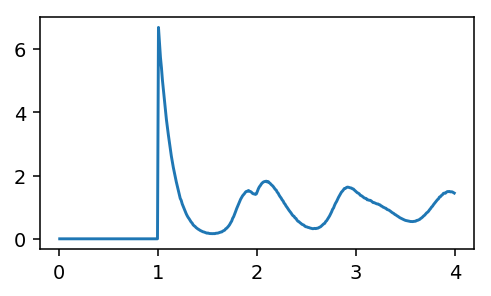

In [5]:
from matplotlib import pyplot
%matplotlib inline
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(analyzer.rdf.getR(), analyzer.rdf.getRDF());